In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
import re
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc, recall_score

## 异常值全部替换为Nan，完成特征选择后再移含除异常值的sample，以最大程度保留样本

In [3]:
cancer_data = pd.read_csv('../../data/cancer_data_v4.csv')
cancer_data.drop(['WBC', 'EO%', 'EO'], axis=1, inplace=True)

In [4]:
cancer_data

,Origin,Age_group,A=male B=female,ID,"A=Case, B=Control",Pattern,Age,Smoke,MCV,ALT,...,TG,TCH,HDL-C,LDL-C,ALP,GGT,CK,LDH-L,HBDH,T-CEA
0,A,Y,B,1,A,A,41,0.0,96.6,19.0,...,0.395216,4.677944,2.546789,2.096241,47.858883,9.591154,70.006565,156.942033,119.394672,1.821957
1,A,Y,A,100,A,A,35,0.0,93.3,28.0,...,1.392946,6.996204,3.193320,4.178865,45.289501,19.339498,48.094659,175.689699,142.475502,1.501278
2,A,Y,A,1000,A,A,50,0.0,93.8,44.0,...,0.965348,4.982533,1.421824,3.328620,60.063449,12.669578,102.144026,186.402651,146.416131,1.407699
3,A,Y,B,1007,A,A,50,200.0,92.8,12.0,...,2.148371,4.771013,1.874396,2.602567,54.924685,10.617295,107.987201,194.973013,150.356760,1.114409
4,A,Y,A,1008,A,A,51,400.0,89.2,24.0,...,1.449960,4.415659,1.395963,2.535694,74.195051,19.852569,88.996883,158.548976,135.157190,1.501278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7787,C,M,A,2489054,B,O,60,25.0,97.4,22.0,...,1.820000,5.390000,1.350000,3.400000,94.000000,49.000000,96.000000,159.000000,119.000000,1.340000
7788,C,Y,A,2491728,B,O,48,0.0,95.5,30.0,...,0.970000,5.220000,1.110000,3.710000,60.000000,65.000000,76.000000,164.000000,129.000000,0.970000
7789,C,M,A,2491799,B,O,56,0.0,NaN,19.0,...,1.190000,5.910000,1.390000,4.030000,124.000000,16.000000,38.000000,128.000000,112.000000,1.380000
7790,C,M,B,509610,B,O,59,25.0,92.8,34.0,...,0.710000,5.390000,1.830000,2.880000,71.000000,28.000000,129.000000,273.000000,232.000000,3.880000


## 中位数填充

In [5]:
for fea in cancer_data.columns[6:]:
    median = cancer_data.groupby(['Age_group', 'A=male B=female'])[fea].median()
    cancer_data.set_index(['Age_group', 'A=male B=female'], inplace=True)
    cancer_data[fea].fillna(median, inplace=True)
    cancer_data.reset_index(inplace=True)

In [6]:
X, y = cancer_data.loc[:,'Age':], cancer_data['A=Case, B=Control']

### 卡方

In [7]:
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

In [8]:
fea_selc_chi = SelectKBest(score_func=chi2, k='all')
fea_selc_chi.fit(X,y)

SelectKBest(k='all', score_func=<function chi2 at 0x0000021EA7CD9CA0>)

In [9]:
chi_fea = pd.DataFrame({'Feature_Chi2':X.columns, 'Score':fea_selc_chi.scores_, 'P-val':fea_selc_chi.pvalues_ })
chi_fea.sort_values(by='Score', ascending=False, inplace=True)
print(chi_fea)
chi_fea = list(chi_fea['Feature_Chi2'])[:20]

   Feature_Chi2          Score          P-val
1         Smoke  753970.249564   0.000000e+00
33           UA    7034.301667   0.000000e+00
39          GGT    6908.584740   0.000000e+00
16          PLT    1480.155621   0.000000e+00
40           CK     656.583784  8.265684e-145
10          HGB     382.904852   2.900918e-85
28          AST     156.363504   7.050736e-36
26         DBIL     144.761931   2.421079e-33
18         LYM%     133.421050   7.313389e-31
8            Cr     118.581272   1.293444e-27
2          MCV      110.173396   8.978350e-26
5           GLO     105.456473   9.700551e-25
42         HBDH      97.076987   6.668346e-23
25         TBIL      91.668488   1.024840e-21
43        T-CEA      80.050055   3.650441e-19
38          ALP      74.475069   6.140889e-18
36        HDL-C      54.948857   1.237073e-13
19        MONO%      51.854852   5.975881e-13
3           ALT      46.568050   8.849135e-12
17        NEUT%      31.972869   1.563409e-08
41        LDH-L      31.109493   2

### 互信息

In [10]:
fea_selc_info = SelectKBest(score_func=mutual_info_classif, k='all')
fea_selc_info.fit(X,y)

SelectKBest(k='all',
            score_func=<function mutual_info_classif at 0x0000021EA83248B0>)

In [11]:
info_fea = pd.DataFrame({'Feature_Info':X.columns, 'Score':fea_selc_info.scores_ })
info_fea.sort_values(by='Score', ascending=False, inplace=True)
print(info_fea)
info_fea = list(info_fea['Feature_Info'])[:20]

   Feature_Info     Score
36        HDL-C  0.582623
13         MCHC  0.580103
31          A/G  0.579838
19        MONO%  0.577885
10          HGB  0.576759
24         BASO  0.576696
11          HCT  0.575862
23         MONO  0.575697
26         DBIL  0.574877
27         IBIL  0.573628
20        BASO%  0.573069
30          ALB  0.571103
22        LYMPH  0.569670
18         LYM%  0.568998
32   Cystatin-C  0.567018
25         TBIL  0.565616
15       RDW-SD  0.564539
29           TP  0.564492
9           RBC  0.559342
16          PLT  0.558213
12          MCH  0.555714
38          ALP  0.552536
17        NEUT%  0.552263
37        LDL-C  0.551335
28          AST  0.550660
34           TG  0.544732
33           UA  0.543778
40           CK  0.543562
35          TCH  0.541169
41        LDH-L  0.540270
42         HBDH  0.536404
39          GGT  0.533243
14       RDW-CV  0.530417
21         NEUT  0.465587
43        T-CEA  0.443476
8            Cr  0.422901
7           BUN  0.398100
1         Sm

## 相关分析

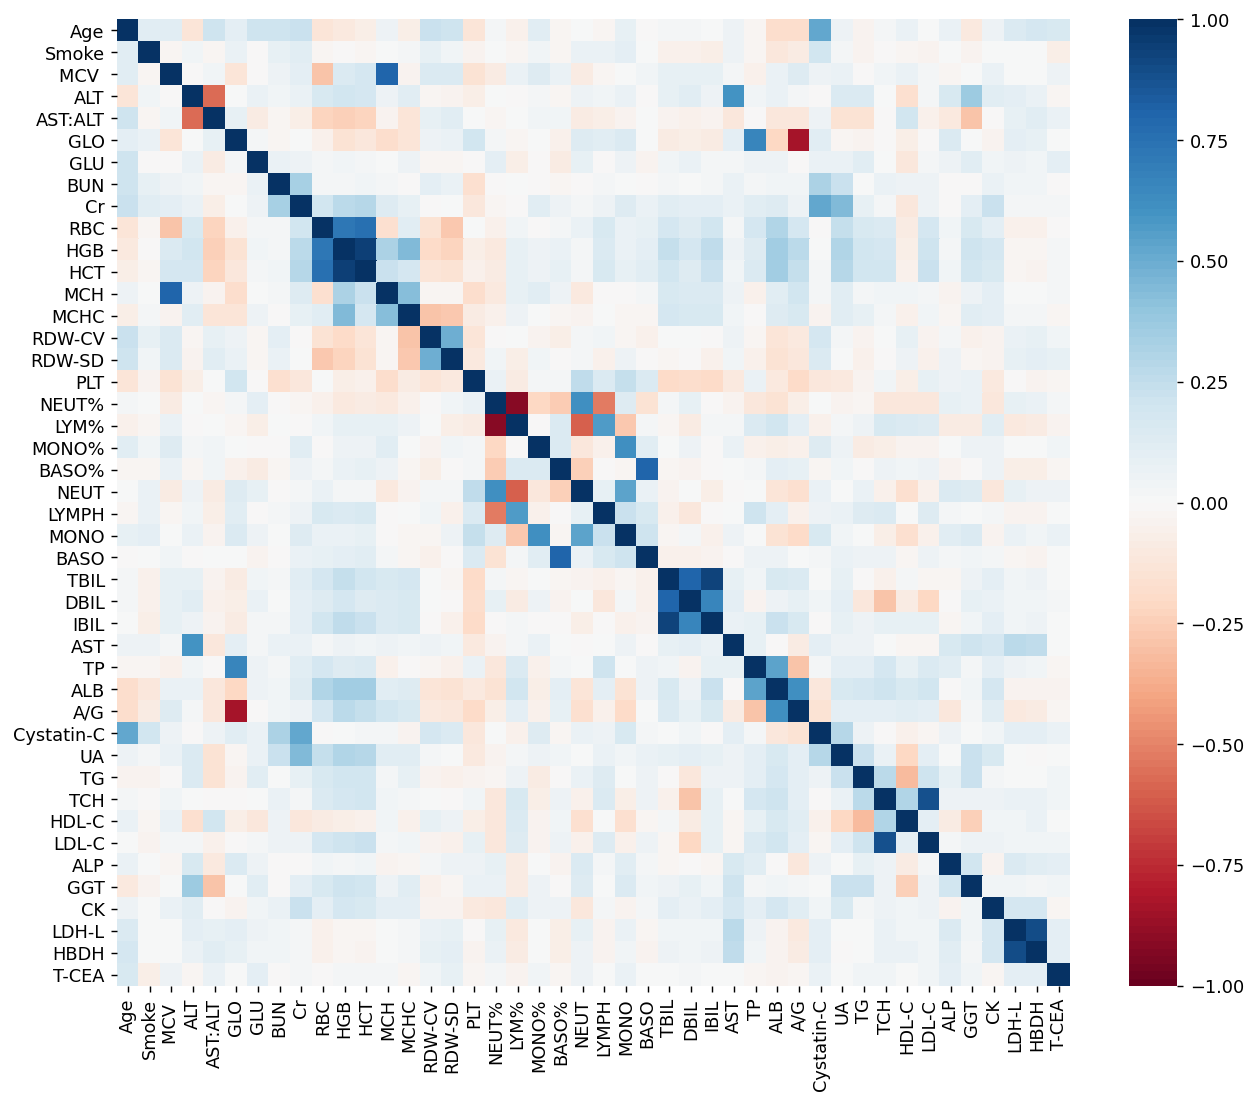

In [12]:
plt.figure(dpi=128, figsize = (12,10))
sns.heatmap(X.corr(), vmin = -1, vmax = 1, cmap=sns.color_palette('RdBu', n_colors=128))
plt.show()

## 根据相关分析结果，移除在卡方与互信息中排名较低的特征

In [13]:
cancer_data.drop(['GLO', 'NEUT%', 'HCT', 'TCH','TBIL', 'IBIL', 'LDH-L'], axis=1, inplace=True)

In [48]:
cancer_data['A=Case, B=Control'] = cancer_data['A=Case, B=Control'].apply(lambda x: 1 if x=='A' else 0)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(cancer_data.drop(['Origin','Age_group','A=male B=female','ID', 'A=Case, B=Control', 'Pattern'], axis=1), cancer_data['A=Case, B=Control'], test_size=0.3)

In [60]:
X_train.shape

(5454, 37)

In [61]:
X_test.shape

(2338, 37)

## 随机森林

In [50]:
rf_clf = RandomForestClassifier(n_estimators=300, oob_score=True,  n_jobs=-1, random_state=0)
rf_clf.fit(X_train, y_train)
print(rf_clf.oob_score_)

0.9343601026769344


In [51]:
rf_importances = pd.DataFrame(rf_clf.feature_importances_, columns = ['Importance'], index=X_train.columns).sort_values(by='Importance', ascending=False)
rf_importances

,Importance
Smoke,0.111305
T-CEA,0.096917
BASO%,0.087043
BASO,0.077120
GGT,0.068116
MCV,0.041245
HDL-C,0.036616
RDW-SD,0.034691
RDW-CV,0.031321
HGB,0.025231


In [52]:
rf_prob = rf_clf.predict_proba(X_test)[:,1]
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_prob)
rf_auc = auc(rf_fpr, rf_tpr)

## AdaBoost

In [55]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200, random_state=0)
ada_clf.fit(X_train, y_train)
score = ada_clf.score(X_test, y_test)
print(score)

0.9482463644140291


In [43]:
ada_importances = pd.DataFrame(ada_clf.feature_importances_, columns = ['Importance'], index=X_train.columns).sort_values(by='Importance', ascending=False)
ada_importances

,Importance
BASO,0.370
BASO%,0.075
T-CEA,0.035
GGT,0.035
AST,0.035
LYMPH,0.030
PLT,0.025
LYM%,0.025
HBDH,0.020
HDL-C,0.020


In [56]:
ada_prob = ada_clf.predict_proba(X_test)[:,1]
ada_fpr, ada_tpr, _ = roc_curve(y_test, ada_prob)
ada_auc = auc(ada_fpr, ada_tpr)

## AUC & ROC

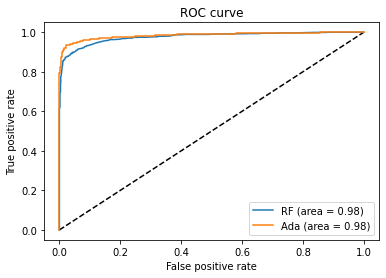

In [57]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(rf_fpr, rf_tpr, label='RF (area = %0.2f)' % rf_auc)
plt.plot(ada_fpr, ada_tpr, label='Ada (area = %0.2f)' % ada_auc)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

In [63]:
from sklearn.externals import joblib

ImportError: cannot import name 'joblib' from 'sklearn.externals' (C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\__init__.py)